# Progression du COVID19 pendant la phase de confinement en France

## Données utilisées
- nb hospitalisation, retour à domicile et décès quotidien sur le COVID19 sur le site data.gouv.fr
- nb habitant par département

In [1]:
from matplotlib import pyplot 
import math
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
from scipy import stats
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
## Importation des données sous forme de dataframe ##
DonneesHosp = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7',sep = ';')
DonneesDep = pd.read_csv('Donnees\Population_departement.csv',sep = ';')
DonneesHosp = DonneesHosp.dropna(how = 'any') # suppression des lignes avec NaN

## Traitement des données

### Mise en forme des données
- analyse de la population globale sans disctinction de sexe
- calcul pour la France entière

In [2]:
# filtrage des lignes uniquement avec la somme homme et femme
Donneesmixte = DonneesHosp[DonneesHosp['sexe']==0]
# suppression colonne sexe et reanimation 
del Donneesmixte['sexe']
del Donneesmixte['rea']
# tri les valeurs par departement et jour
Dj = Donneesmixte.sort_values(by = ['dep', 'jour']) 
# Remise en forme du numero de département sur 2 chiffres minimum (0x)
for i in range(len(DonneesDep)-1): # Parcours des lignes dans l'ordre département + jour
    if len(DonneesDep.loc[DonneesDep.index[i], 'CODDEP']) == 1:
        DonneesDep.loc[DonneesDep.index[i], 'CODDEP'] = '0' + DonneesDep.loc[DonneesDep.index[i], 'CODDEP']
# Jointure sur le département pour récupérer le nombre d'habitant (PTOT)
Dj = pd.merge(Dj, DonneesDep, left_on = ['dep'], right_on = ['CODDEP'])
# Suppression de colonne
del Dj['CODDEP']
del Dj['NBARR']
del Dj['NBCAN']
del Dj['PMUN']
# Calcul pour la France
for j in Dj[Dj['dep']== '01'].itertuples(): # itération sur tous les jours
    ligne = len(Dj) # ajoute une ligne à la fin
    Dj.loc[ligne,['dep']] = '999'
    Dj.loc[ligne,['jour']] = j.jour
    Dj.loc[ligne,['DEP']] = 'France'
    Dj.loc[ligne,['hosp']] =  Dj[Dj['jour'] == j.jour]['hosp'].sum()  
    Dj.loc[ligne,['rad']] =  Dj[Dj['jour'] == j.jour]['rad'].sum()
    Dj.loc[ligne,['dc']] =  Dj[Dj['jour'] == j.jour]['dc'].sum()
    Dj.loc[ligne,['NBCOM']] =  Dj[Dj['jour'] == j.jour]['NBCOM'].sum()
    Dj.loc[ligne,['PTOT']] =  Dj[Dj['jour'] == j.jour]['PTOT'].sum()
Dj = Dj.reset_index(drop = True) # réindexe

### Calcul des indicateurs : entrées, sorties, nb entree/hosp, tendance
- entrées en hospitalisation
- sorties en hospitalisation : guérison et décès
- rapport des entrées sur le nombre d'hospitalisation (pour 100 000 habitants)
- lissage de ce rapport sur 1 semaine pour améliorer la lisibilité
- calcul de la tendance de ce rapport sur 2 semaines (pente)

In [3]:
# Initialisation de colonne de colonnnes
Dj['Entree'] = 0 # Colonne des entrées en hospitalisation
Dj['Sortie'] = 0 # Colonne des sorties en hospitalisation
Dj['Thosp'] = 0 # proportion : nb d'hospitalisation par 100 000 habitatns
Dj['CThosp'] = -1 # classement de la proportion de cas (en cluster)
Dj['Treprod'] = 0 # vitesse de progression : nb entrée  pour 100 hospitalisation
Dj['Treprodmoy'] = 0 # vitesse moyyenne de progression sur 7 jours : nb entrée  pour 100 hospitalisation
Dj['CTreprod'] = 0 # Classement de la vitesse (en cluster)
Dj['tendance'] = 0 # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours
Dj['incoherence'] = False # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours

# Calcul entree, sortie, rapport entree/hospitalisation et tendance
dep = '00'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    Dj.at[i, 'Thosp'] = round(Dj.at[i, 'hosp'] / Dj.at[i, 'PTOT'] * 100000 )
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'dep'] != dep:
            dep = Dj.at[i, 'dep']
            print('\r','departement : ', dep, end='')
        # Calcul des entrées, sorties et taux de reproduction
        if i > 0 and Dj.at[i, 'dep'] == Dj.at[i-1, 'dep']: # le point précédent est dans le même département 
            Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']  + Dj.at[i, 'dc'] - Dj.at[i-1, 'dc'] 
            if Sortie > Dj.at[i-1, 'hosp']: 
                Sortie = Dj.at[i-1, 'hosp']
                Dj.at[i, 'incoherence'] = True
            Entree = Sortie + Dj.at[i, 'hosp'] - Dj.at[i-1, 'hosp']
            if Entree > 0: 
                Dj.at[i, 'Entree'] = Entree 
                if Dj.at[i, 'hosp'] > 10: # en dessous de 10 hosp, le taux de reproduction a peu de sens
                    Dj.at[i, 'Treprod'] = round(Entree / Dj.at[i, 'hosp'] * 100) 
            if Sortie > 0: 
                Dj.at[i, 'Sortie'] = Sortie
            elif Sortie < 0:
                Dj.at[i, 'incoherence'] = True
            Dj.at[i, 'Treprodmoy'] = 0.7 * Dj.at[i-1, 'Treprodmoy'] + 0.3 * Dj.at[i, 'Treprod']
                
         # Calcul de la vitesse  moyenne sur la dernière semaine
        idebut = max(i-6,0)
        Djp = Dj.loc[idebut:i, ['dep','Treprod']] # les 7 dernières lignes
        Djp = Djp[(Djp['dep'] == Dj.at[i, 'dep'])] # conserve le département
       # Dj.at[i, 'Treprodmoy'] = round( Djp['Treprod'].mean()) # calcul la moyenne de la vitesse 
       
    
    if Dj.at[i, 'jour'] == Dj['jour'].max(): # Calcul uniquement sur le dernier jour    
    # Calcul de la tendance sur les 2 dernières semaines
        idebut = max(i-13,0)
        Djp1 = Dj.loc[idebut:i, ['dep','Treprod','incoherence']] # les 14 dernières lignes
        Djp1 = Djp1[(Djp1['dep'] == Dj.at[i, 'dep'])] # conserve le département
        for j in range(len(Djp1)):
            Djp1.loc[Djp1.index[j],'x'] = j # creation d'une abscisse x pour la régression lineaire
            if Djp1.loc[Djp1.index[j],'incoherence'] == True: # s'il y a une donnee incoherente 
                 Dj.at[i, 'incoherence'] = True 
        if Djp1['Treprod'].mean() > 0:
            Djp1.loc[:,'Treprod'] = Djp1['Treprod']/Djp1['Treprod'].mean()*100 # normalise la vitesse à 100
        else : 
            Djp1.loc[:,'Treprod'] = 0
        if len(Djp1) > 7:
            lr = stats.linregress( Djp1['x'].values,Djp1['Treprod'].values) # regerssion lineaire sur la vitesse
            Dj.at[i, 'tendance'] = round(lr[0]* 10)/ 10 # recupère la pente
            #print(' regression lineaire',Dj.loc[i, 'tendance'] , Djp2['x'].values )
        

 departement :  999

### Classification des départements
- par nombre d'hospitalisation (ramené à 100 000 habitant)
- par nombre d'entrées (ramené à 100 hospitalisation)

In [4]:
## Regroupement des départements en taux d'hospitalisation final ##

# x = proportion d'hospitalisation sur la date la plus récente
x = Dj[Dj['jour']== Dj['jour'].max()]['Thosp']
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
    else:
        intensite[i] ='1' # proportion intermédiaire
# integration des résultats dans le tableau dep+jour
Dj.loc[Dj['jour'] == Dj['jour'].max(),'CThosp'] = intensite[model.labels_]


## Regroupement des départements par taux de reproduction final ##

x = Dj[Dj['jour']== Dj['jour'].max()]['Treprodmoy'] # x = taux d'hospitalisation sur la date la plus récente
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
    else:
        intensite[i] ='1' # proportion intermédiaire
# integration des résultats dans le tableau dep+jour
Dj.loc[Dj['jour'] == Dj['jour'].max(),'CTreprodf'] = intensite[model.labels_]


## Regroupement des départements par taux de reproduction sur toute la durée ##
x = Dj['Treprodmoy'] # x = taux de reproduction moyen sur toute la période
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
centreTreprod  = np.zeros((3, 1), dtype = float)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
        centreTreprod [2] = model.cluster_centers_[i]
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
        centreTreprod [0] = model.cluster_centers_[i]
    else:
        intensite[i] ='1' # proportion intermédiaire
        centreTreprod [1] = model.cluster_centers_[i]
# integration des résultats dans le tableau dep+jour
Dj.loc[:,'CTreprod'] = intensite[model.labels_]


## Visualisation des résultats

###  Evolutions des hospitalisations par département
- en ROUGE, les départements où le virus se propage car le nombre d'hospitalisation et d'entrée sont elevés 
- en ORANGE, les départements pour lesquels il faut être vigilant car :
     - soit le virus se propage peu (peu d'entrée) mais le nombre d'hospitalisation est encore élevé
     - soit le nombre d'hospitalisation est dans la moyenne mais le virus se propage (beaucoup d'entrée)
 - en GRIS, les départements avec une évolution proche de la moyenne nationale (en NOIR)
 - en VERT, les département avec une évolution plus faible que la moyenne.

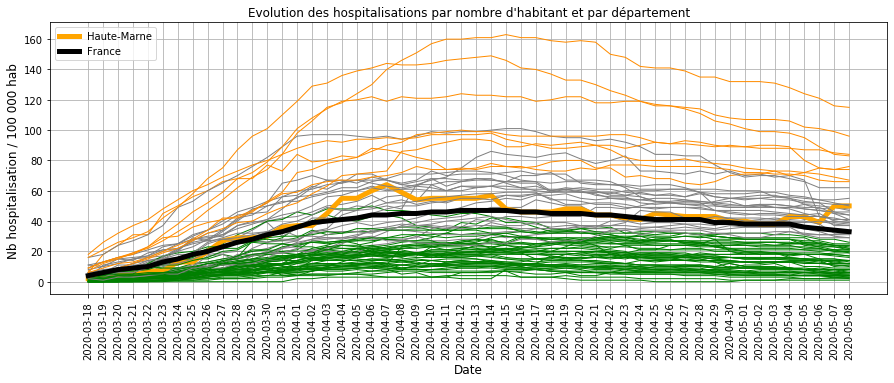

In [5]:
# Visualisation du taux d'hospitalisation de l'ensemble des départements ##
def courbe_Thosp(dep):
    fig1 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if Dj.at[i,'jour'] == Dj['jour'].max() and Dj.at[i,'incoherence'] == False: # recherche de la dernière ligne du département
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            epaisseur = 1
            legende =''
            if Dj.at[i,'CTreprod'] > 0 :col = 'orange';epaisseur = 5;legende =Dj.at[i,'DEP']
            elif Dj.at[i,'CThosp'] == 2 :
                if  Dj.at[i,'CTreprod'] == 0 :col = 'darkorange';epaisseur = 1
                else:col = 'red';epaisseur = 3;legende =Dj.at[i,'DEP']
            elif Dj.at[i,'CThosp'] == 0 and Dj.at[i,'CTreprod'] == 0 :col ='green'
            else:col ='grey'
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black';legende =Dj.at[i,'DEP']
            elif Dj.at[i,'DEP'] == dep:epaisseur = 5 ;col = 'blue';legende =Dj.at[i,'DEP']
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],col,linewidth = epaisseur,label = legende)
    # Paramètres généraux
    pyplot.legend(loc='upper left')
    pyplot.title("Evolution des hospitalisations par nombre d'habitant et par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()  
    fig1.savefig('Images\Evolution des hospitalisations par departement_' + dep + '.png')
courbe_Thosp('France')

### Tableau détaillé des départements critiques
- hosp : nombre d'hospitalisation du département (dep)
- Thosp : nombre d'hospitalisation pour 100 000 habitants
- Treprodmoy : nombre d'entrée moyenné sur 1 semaine pour 100 hospitalisation
- tendance  : augmentation/baisse quotidienne du nombre d'entrée pour 100 hospitalisation

In [6]:
Dj.loc[(Dj['jour'] == Dj['jour'].max()) & (Dj['incoherence'] == False) \
           & ((Dj['CThosp'] ==2) | (Dj['CTreprod'] > 0))  & (Dj['dep'] != '999'), \
           ['dep','DEP','hosp','Thosp','Treprodmoy','CTreprod','tendance']].sort_values(by = ['Thosp', 'Treprodmoy' ],ascending = False)


,dep,DEP,hosp,Thosp,Treprodmoy,CTreprod,tendance
4939,94,Val-de-Marne,1606.0,115,1,0,0
4835,92,Hauts-de-Seine,1557.0,96,1,0,-5
4887,93,Seine-Saint-Denis,1367.0,84,1,0,1
3951,75,Paris,1819.0,83,0,0,-6
2911,55,Meuse,146.0,76,2,0,1
4783,91,Essonne,964.0,74,1,0,-4
3535,67,Bas-Rhin,765.0,67,1,0,0
4991,95,Val-d'Oise,813.0,66,1,0,-2
2755,52,Haute-Marne,90.0,50,8,1,13


### Commentaires à la date du 7 mai 2020 :

Les départements critiques sont :
- les 8 premiers départements ci-dessus dont le taux d'hospitalisation est élevé mais avec une tendance à la baisse.
- la Haute-Marne dont les entrées sont repartis à la hausse (ORANGE GRAS sur la courbe ci-dessus)

De plus il exsite de nombreux départements (VERT) qui ont été relativement peu touchés (10 fois moins).

### Evolution des entrées en hospitalisation par département

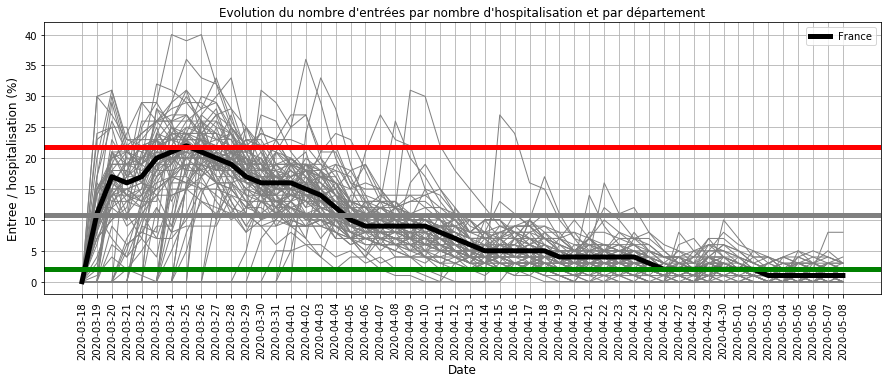

In [7]:
## Visualisation du taux d'hospitalisation de l'ensemble des départements pour vérifer la cohérence ##
def courbe_TEntree(dep):
#dep = '63'
    fig2 = pyplot.figure(2,figsize = (15, 5))
    for i in range(len(Dj)):
        if Dj.at[i,'jour'] == Dj['jour'].max(): # recherche de la dernière ligne du département
            couleur = 'grey'
            epaisseur = 1
            legende =''
            if  Dj.at[i,'dep'] == '999' : couleur = 'black' ; epaisseur = 5 ; legende='France'
            elif  Dj.at[i,'DEP'] == dep : couleur = 'blue' ; epaisseur = 5 ; legende=Dj.at[i,'DEP']
        # Courbe du département
            if Dj.at[i, 'incoherence'] == False:
                Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Treprodmoy']] # récupération du département
                pyplot.plot(Djdep['jour'],Djdep['Treprodmoy'],couleur,linewidth=epaisseur,label =legende)
    # Paramètres généraux
    pyplot.axhline(y = centreTreprod [2],color ='red',linewidth = 5)
    if centreTreprod [1] != 0 :
        pyplot.axhline(y = centreTreprod [1],color ='grey',linewidth = 5)
    pyplot.axhline(y = centreTreprod [0],color ='green',linewidth = 5)
    pyplot.title("Evolution du nombre d'entrées par nombre d'hospitalisation et par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Entree / hospitalisation (%)' , fontsize = 12) # titre des ordonnées
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.legend(loc='upper right')
    pyplot.show() 
courbe_TEntree('France')

### Commentaires
2 phases dans l'évolution :
- jusqu'au 25 mars, tous les départements ont eu une augmentation significative des entrées :
    - cela traduit une accélération de la circulation du virus,
    - et justifie à posteriori le passage en confinement pour la france entière,
- à partir du 15 avril, le nombre d'entrée a globalement fortement baissé par rapport aux nombres d'hospitalisation
    - cela traduit une capacité du virus à beaucoup moins se transmettre (8 fois moins d'entrée),
    - ce qui montre l'impact significatif d'un confinement.

### Evolution des hospitalisations pour la France entière

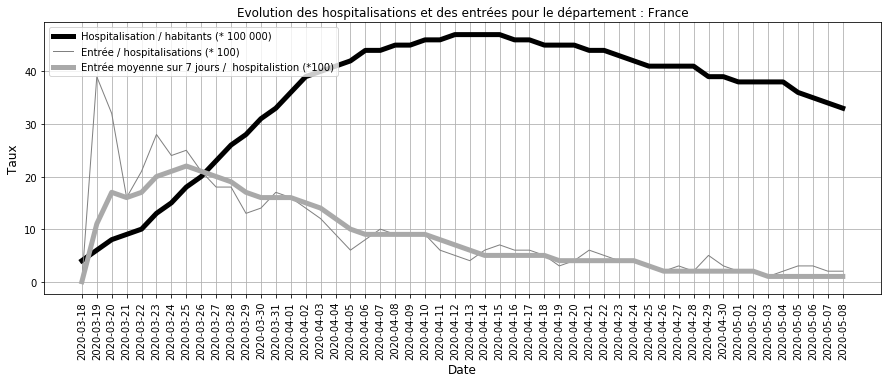

In [8]:
## Affichage  pour un département
def courbe_departement(dep):
    fig3 = pyplot.figure(2,figsize = (15, 5))
    if dep == 'France': couleur = 'black'
    else: couleur = 'blue' ;
    pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Thosp'],couleur,linewidth = 5,label='Hospitalisation / habitants (* 100 000)')
    pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprod'],'grey',linewidth = 1,label="Entrée / hospitalisations (* 100)")
    pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprodmoy'],'darkgrey',linewidth = 5,label="Entrée moyenne sur 7 jours /  hospitalistion (*100)")
    pyplot.legend(loc='upper left')
    pyplot.grid()
    pyplot.title("Evolution des hospitalisations et des entrées pour le département : "+ Dj[Dj['DEP'] == dep]['DEP'].max() )
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Taux' , fontsize = 12) # titre des ordonnées
    # mise en forme du label des x (rotation verticale)
    for label in pyplot.gca().xaxis.get_ticklabels():
        label.set_rotation(90)
    pyplot.show()  
courbe_departement('France')

### Evolution des hospitalisations sur quelques départements

In [9]:
# Sert à faire une interface qui selectionne un département
# rq : la sauvegarde en Markdown ne se fait pas correctement
def courbes_departement(dep):
    courbe_departement(dep)
    courbe_Thosp(dep)
    courbe_TEntree(dep)
interact(courbes_departement, dep =  Dj[Dj['jour'] == Dj['jour'].max()]['DEP'],value='Puy-de-Dôme')

interactive(children=(Dropdown(description='dep', options=('Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence'…

<function __main__.courbes_departement(dep)>

#### Département de la Seine-Saint-Denis : les hospitalisations sont élevée mais la tendance est à la baisse
c'est un exemple de département dont :
- le nombre d'hospitalisation est certes élevé (BLEUE sur le deuxième graphique)
- mais le nombre d'entrée est devenu faible (GRIS sur le 1er graphique) ce qui se traduit par une tendance à la baisse (BLEU sur le 1er graphique)

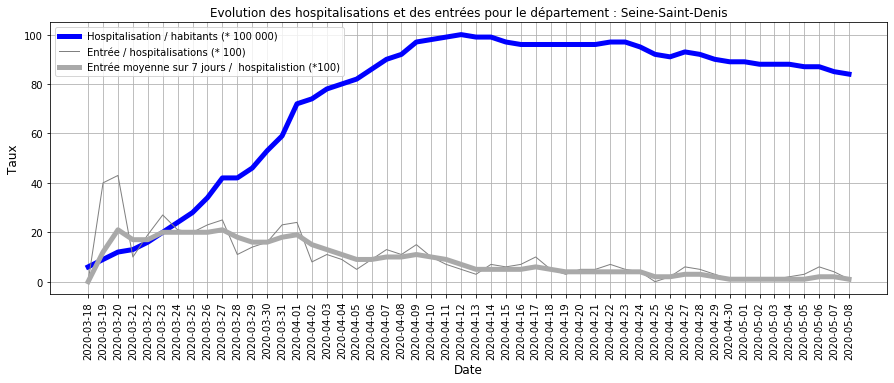

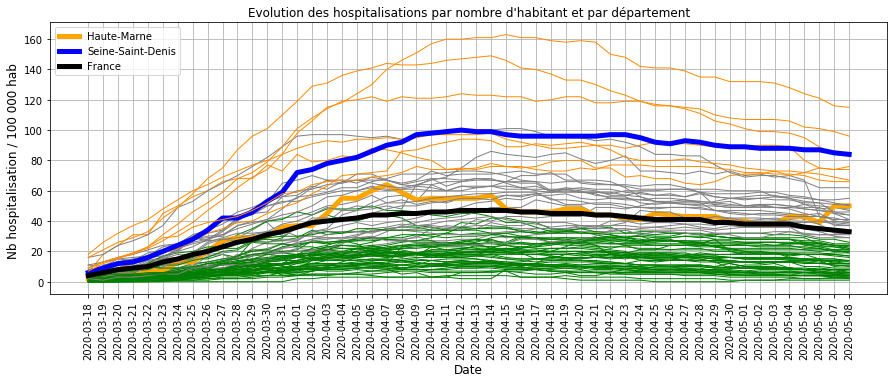

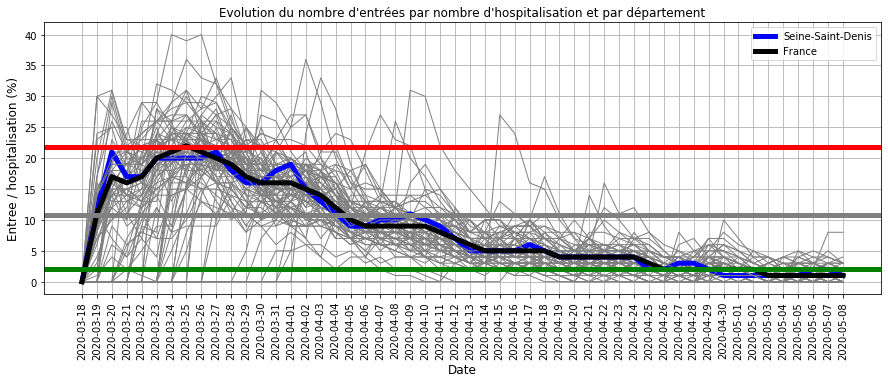

In [10]:
courbes_departement('Seine-Saint-Denis')

#### Département de la Haute-Marne : les entrées repartent à la hausse
- le nombre d'entrée repart à la hausse (GRIS/BLEU sur le 1er graphique)
- Cette hausse est élevée par rapport à la tendance des autres département (BLEU 3e graphique)
- mais le nombre d'hospitalisation est encore dans la tendance moyenne (BLEU 2e graphique)

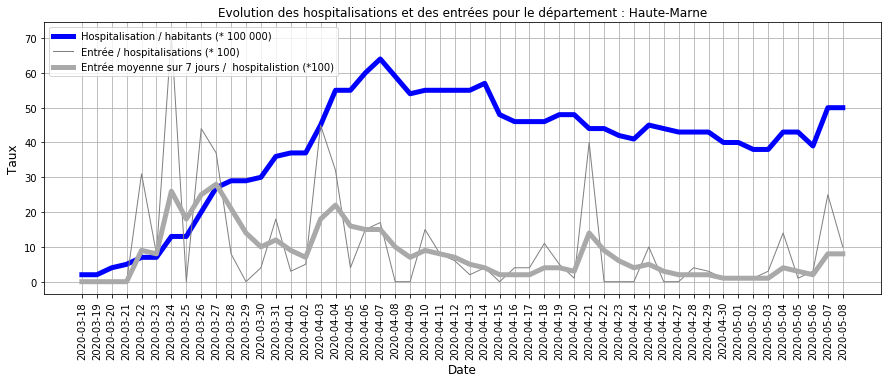

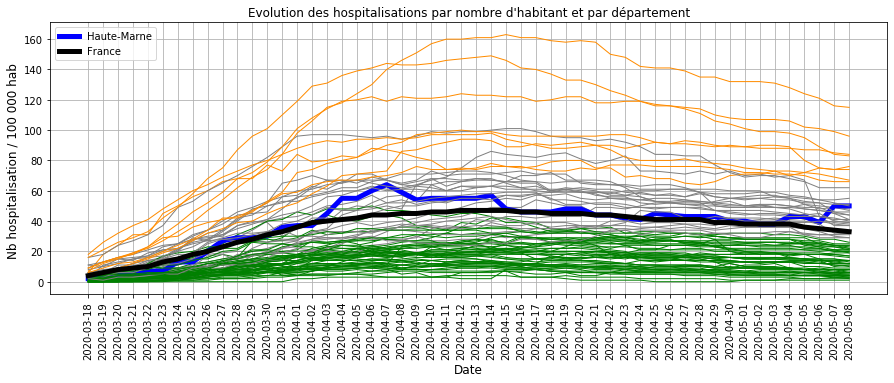

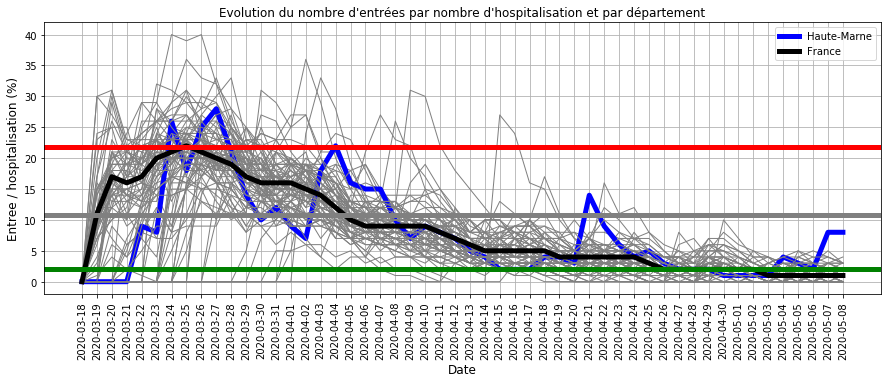

In [11]:
courbes_departement('Haute-Marne')

## Sauvegarde des fichiers

### Sous Markdown

In [12]:
# Commande enrgistrement
!jupyter nbconvert --to markdown --no-input  Evolution_confinement.ipynb

[NbConvertApp] Converting notebook Evolution_confinement.ipynb to markdown
[NbConvertApp] Support files will be in Evolution_confinement_files\
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Writing 6234 bytes to Evolution_confinement.md


### Sous HTML

In [13]:
# Commande enrgistrement
!jupyter nbconvert --to html --no-input  Evolution_confinement.ipynb

[NbConvertApp] Converting notebook Evolution_confinement.ipynb to html
[NbConvertApp] Writing 1303923 bytes to Evolution_confinement.html


## Fin